In [13]:
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial' 
plt.rcParams['font.size'] = 12
plt.rcParams['pdf.fonttype'] = 42

from matplotlib.colors import LinearSegmentedColormap
cm_data = np.loadtxt("../../ScientificColourMaps7/batlow/batlow.txt")[::-1]
batlow_map = LinearSegmentedColormap.from_list('batlow', cm_data)

cm_data = np.loadtxt("../../ScientificColourMaps7/bamako/bamako.txt")[::-1]
bamako_map = LinearSegmentedColormap.from_list('bamako', cm_data)

import cartopy.crs as ccrs

### Preliminaries

In [14]:
###############################
# Set paths
# UPDATE THIS FOR REPRODUCTION
###############################
path_in = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/uc_results/'

In [43]:
def plot_single_point(ds, var_id, lat, lon, iav):
    # Select lat/lon coord
    ds = ds.sel(lat=lat, lon=lon, method='nearest')

    # Get fractions
    Utotal = ds.sel(uncertainty='model') + ds.sel(uncertainty='scenario') + ds.sel(uncertainty='ensemble')
    if iav:
         Utotal = Utotal + ds.sel(uncertainty='variability')

    Ufrac_model = ds.sel(uncertainty='model') / Utotal
    Ufrac_scenario = ds.sel(uncertainty='scenario') / Utotal
    Ufrac_ensemble = ds.sel(uncertainty='ensemble') / Utotal
    if iav:
        Ufrac_iav = ds.sel(uncertainty='variability') / Utotal
    
    # Construct plotting dict
    uncert_dict = {
    'Scenario': Ufrac_scenario[var_id].to_numpy(),
    'Model': Ufrac_model[var_id].to_numpy(),
    'Downscaling': Ufrac_ensemble[var_id].to_numpy(),
    }
    if iav:
        uncert_dict.update({'Variability': Ufrac_iav[var_id].to_numpy()})

    # Make plot
    fig, ax = plt.subplots()
    
    ax.stackplot(np.arange(2020, 2095),
             uncert_dict.values(),
             labels=uncert_dict.keys(),
             alpha=1, colors=['#7fc97f', '#beaed4', '#fdc086', iav*'#ffff99'],
             edgecolor='white',
             lw=1)

    ax.legend(loc='upper left', ncol=2, columnspacing=1, handletextpad=0.1)
    ax.set_ylim([0,1])
    ax.set_xlim([2020,2094])
    ax.set_xticks([2030, 2050, 2070, 2090])
    ax.set_ylabel('Relative Contribution')

    plt.show()

In [50]:
def plot_map(ds, var_id, iav, title, store):
    # Get fractions
    Utotal = ds.sel(uncertainty='model') + ds.sel(uncertainty='scenario') + ds.sel(uncertainty='ensemble')
    if iav:
         Utotal = Utotal + ds.sel(uncertainty='variability')

    Ufrac_model = ds.sel(uncertainty='model') / Utotal
    Ufrac_scenario = ds.sel(uncertainty='scenario') / Utotal
    Ufrac_ensemble = ds.sel(uncertainty='ensemble') / Utotal
    if iav:
        Ufrac_iav = ds.sel(uncertainty='variability') / Utotal
    
    # Resample to 3 epochs
    early_start, early_end = 2020, 2029
    mid_start, mid_end = 2050, 2059
    late_start, late_end = 2080, 2089

    Ufrac_model_early = 100 * Ufrac_model.sel(time = slice(early_start, early_end)).mean(dim='time')
    Ufrac_scenario_early = 100 * Ufrac_scenario.sel(time = slice(early_start, early_end)).mean(dim='time')
    Ufrac_ensemble_early = 100 * Ufrac_ensemble.sel(time = slice(early_start, early_end)).mean(dim='time')

    Ufrac_model_mid = 100 * Ufrac_model.sel(time = slice(mid_start, mid_end)).mean(dim='time')
    Ufrac_scenario_mid = 100 * Ufrac_scenario.sel(time = slice(mid_start, mid_end)).mean(dim='time')
    Ufrac_ensemble_mid = 100 * Ufrac_ensemble.sel(time = slice(mid_start, mid_end)).mean(dim='time')

    Ufrac_model_late = 100 * Ufrac_model.sel(time = slice(late_start, late_end)).mean(dim='time')
    Ufrac_scenario_late = 100 * Ufrac_scenario.sel(time = slice(late_start, late_end)).mean(dim='time')
    Ufrac_ensemble_late = 100 * Ufrac_ensemble.sel(time = slice(late_start, late_end)).mean(dim='time')
    
    if iav:
        Ufrac_iav_early = 100 * Ufrac_iav.sel(time = slice(early_start, early_end)).mean(dim='time')
        Ufrac_iav_mid = 100 * Ufrac_iav.sel(time = slice(mid_start, mid_end)).mean(dim='time')
        Ufrac_iav_late = 100 * Ufrac_iav.sel(time = slice(late_start, late_end)).mean(dim='time')
    
    # Plot
    cmap = bamako_map
    
    if iav:
        fig, axs = plt.subplots(ncols=4, nrows=3,
                                figsize=(16,6),
                                subplot_kw=dict(projection=ccrs.PlateCarree()))
    else:
        fig, axs = plt.subplots(ncols=3, nrows=3,
                                figsize=(16,8),
                                subplot_kw=dict(projection=ccrs.PlateCarree()))
    axs = axs.flatten()

    fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.01)

    # List with all results
    Ufrac_all = [Ufrac_scenario_early[var_id], Ufrac_model_early[var_id], Ufrac_ensemble_early[var_id],
                 Ufrac_scenario_mid[var_id], Ufrac_model_mid[var_id], Ufrac_ensemble_mid[var_id],
                 Ufrac_scenario_late[var_id], Ufrac_model_late[var_id], Ufrac_ensemble_late[var_id]]
    if iav:
        Ufrac_all.insert(3, Ufrac_iav_early[var_id])
        Ufrac_all.insert(7, Ufrac_iav_mid[var_id]) 
        Ufrac_all.insert(11, Ufrac_iav_late[var_id])
    
    # Loop through and make each plot
    for i in range(len(axs)):
        ax=axs[i]
        p = Ufrac_all[i].plot(ax=ax,
                          transform=ccrs.PlateCarree(),
                          vmin=0., vmax=100., levels=11,
                          cmap=cmap, add_colorbar=False)
        ax.coastlines()
        ax.set_title('')
        ax.text(0.08, 0.15, "{:.0f}%".format(Ufrac_all[i].mean()),
                fontsize=10,
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax.transAxes,
                bbox=dict(facecolor='silver', edgecolor='silver', alpha=0.5))

    # Set titles
    axs[0].set_title('Scenario uncertainty', fontsize=12)
    axs[1].set_title('Model uncertainty', fontsize=12)
    axs[2].set_title('Downscaling uncertainty', fontsize=12)
    if iav:
        axs[3].set_title('Inter-annual variability', fontsize=12)

    axs[0].text(-185, 15, '2020-2029', va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor')
    if iav:
        axs[4].text(-185, 15, '2050-2059', va='bottom', ha='center',
                    rotation='vertical', rotation_mode='anchor')
        axs[8].text(-185, 15, '2080-2089', va='bottom', ha='center',
                    rotation='vertical', rotation_mode='anchor')
    else:
        axs[3].text(-185, 15, '2050-2059', va='bottom', ha='center',
                    rotation='vertical', rotation_mode='anchor')
        axs[6].text(-185, 15, '2080-2089', va='bottom', ha='center',
                    rotation='vertical', rotation_mode='anchor')

    # Single colorbar
    cbar_ax = fig.add_axes([0.2, 0.16, 0.6, 0.02])

    cbar = fig.colorbar(p, cax=cbar_ax,
                        orientation='horizontal',
                        label='Fraction of total uncertainty (%)')
    
    # Overall title
    fig.suptitle(title, fontsize=12, fontweight='bold', y=0.97)
    
    # save or show
    if store:
        plt.savefig('../figs/' + store + '.png', dpi=600)
    else:
        plt.show()

## UC plots with IAV

### Annual averages

In [64]:
# Read
ds_uc = xr.open_dataset(path_in + 'hs09_iav/avg.nc').isel(member_id=0)

ds_iav = xr.open_dataset(path_in + 'hs09_iav/avg_iav.nc').isel(member_id=0)
ds_iav = ds_iav.expand_dims(dim={'time':np.arange(2020,2095)}).assign_coords(uncertainty = 'variability')

ds = xr.concat([ds_iav, ds_uc], dim='uncertainty')

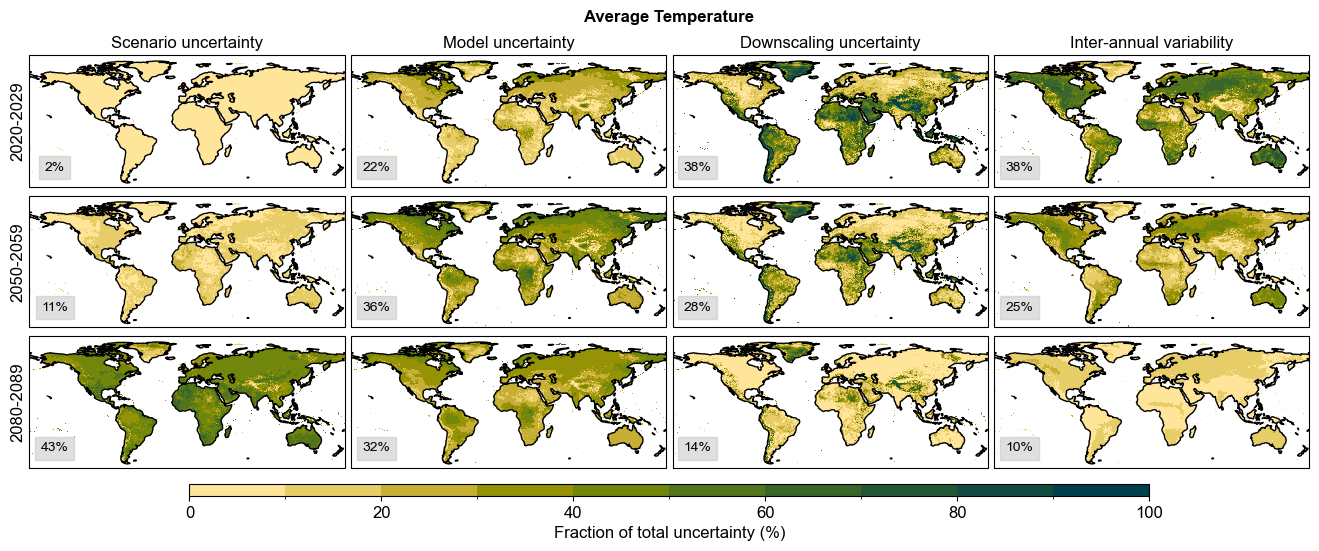

In [65]:
plot_map(ds, 'tas', True, 'Average Temperature', 'tas_avg_iav')

In [55]:
# Seattle
# plot_single_point_iav(ds, 'tas', 47.6, -122.3)

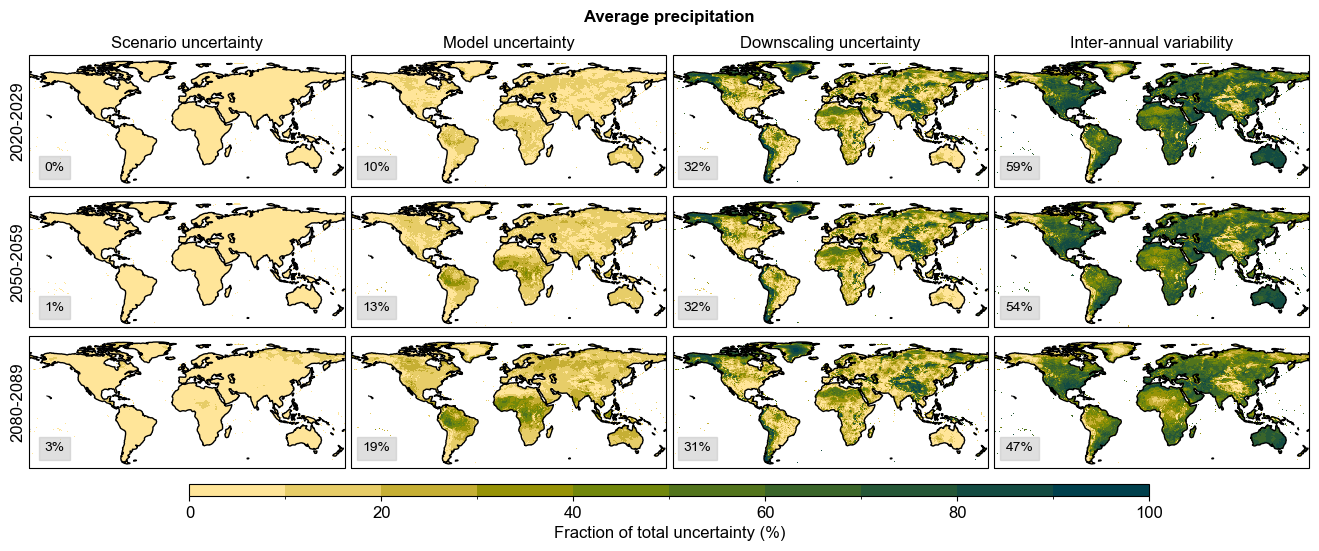

In [66]:
plot_map(ds, 'pr', True, 'Average precipitation', 'pr_avg_iav')

In [ ]:
# Seattle
# plot_single_point_iav(ds, 'pr', 47.6, -122.3)

### 1-day max

In [25]:
# Read
ds_uc = xr.open_dataset(path_in + 'hs09_iav/max.nc').isel(member_id=0)

ds_iav = xr.open_dataset(path_in + 'hs09_iav/max_iav.nc').isel(member_id=0)
ds_iav = ds_iav.expand_dims(dim={'time':np.arange(2020,2095)}).assign_coords(uncertainty = 'variability')

ds = xr.concat([ds_iav, ds_uc], dim='uncertainty')

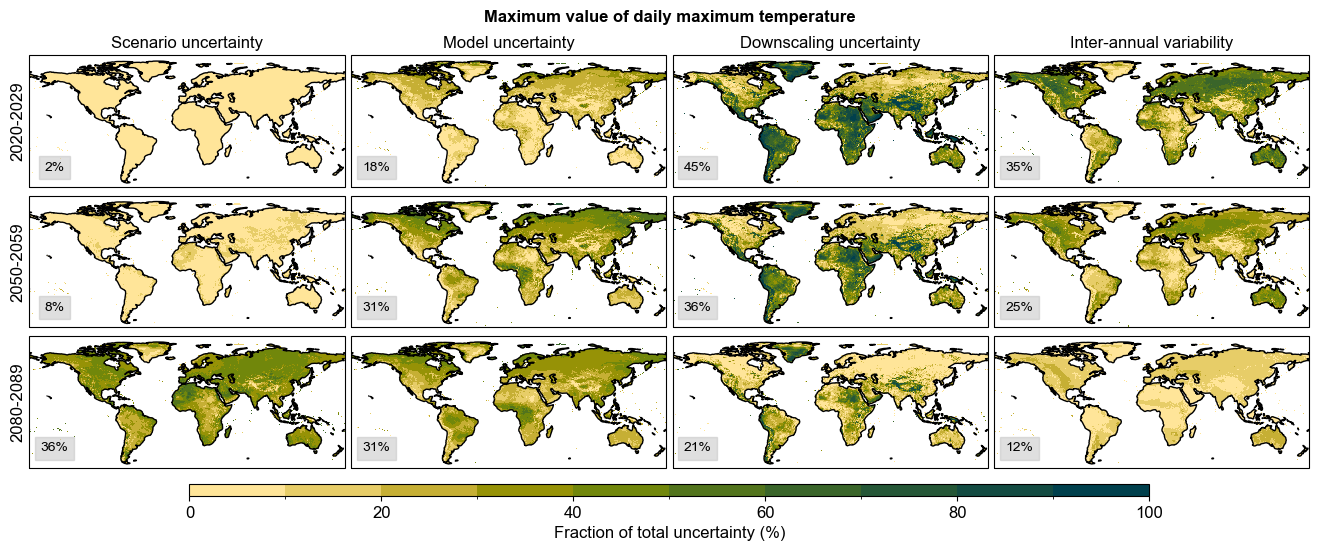

In [58]:
plot_map(ds, 'tasmax', True, 'Maximum value of daily maximum temperature', 'tasmax_max_iav')

In [ ]:
# Seattle
# plot_single_point_iav(ds, 'tasmax', 47.6, -122.3)

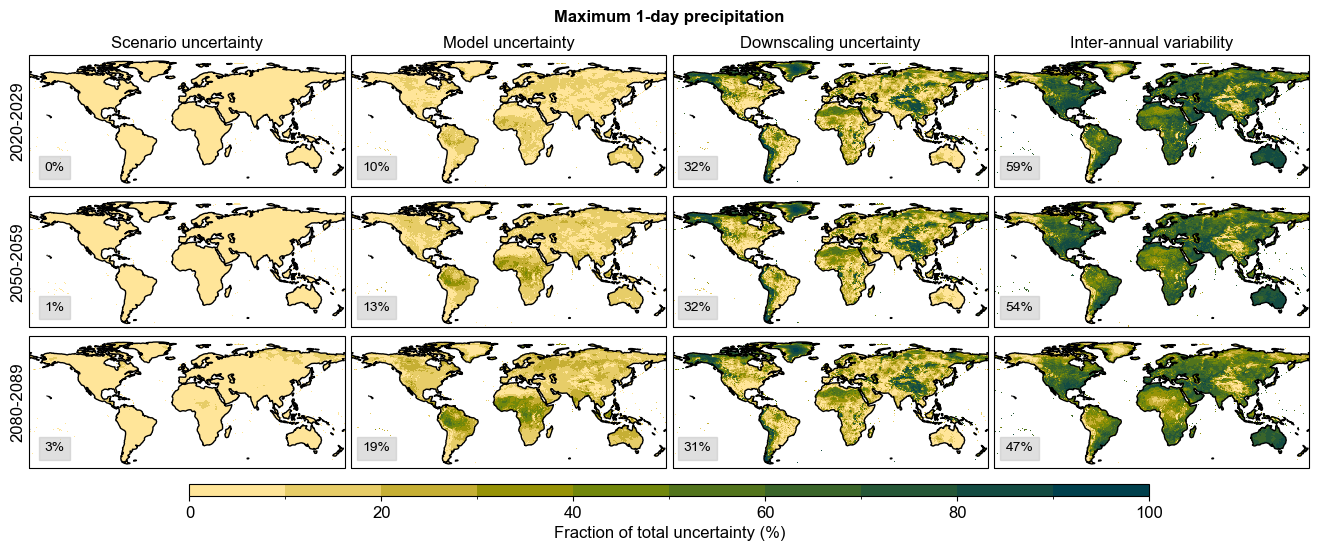

In [57]:
plot_map(ds, 'pr', True, 'Maximum 1-day precipitation', 'pr_max_iav')

In [29]:
# Seattle
# plot_single_point_iav(ds, 'pr', 47.6, -122.3)

### 5-day max (pr)

In [59]:
# Read
ds_uc = xr.open_dataset(path_in + 'hs09_iav/max5d.nc').isel(member_id=0)

ds_iav = xr.open_dataset(path_in + 'hs09_iav/max5d_iav.nc').isel(member_id=0)
ds_iav = ds_iav.expand_dims(dim={'time':np.arange(2020,2095)}).assign_coords(uncertainty = 'variability')

ds = xr.concat([ds_iav, ds_uc], dim='uncertainty')

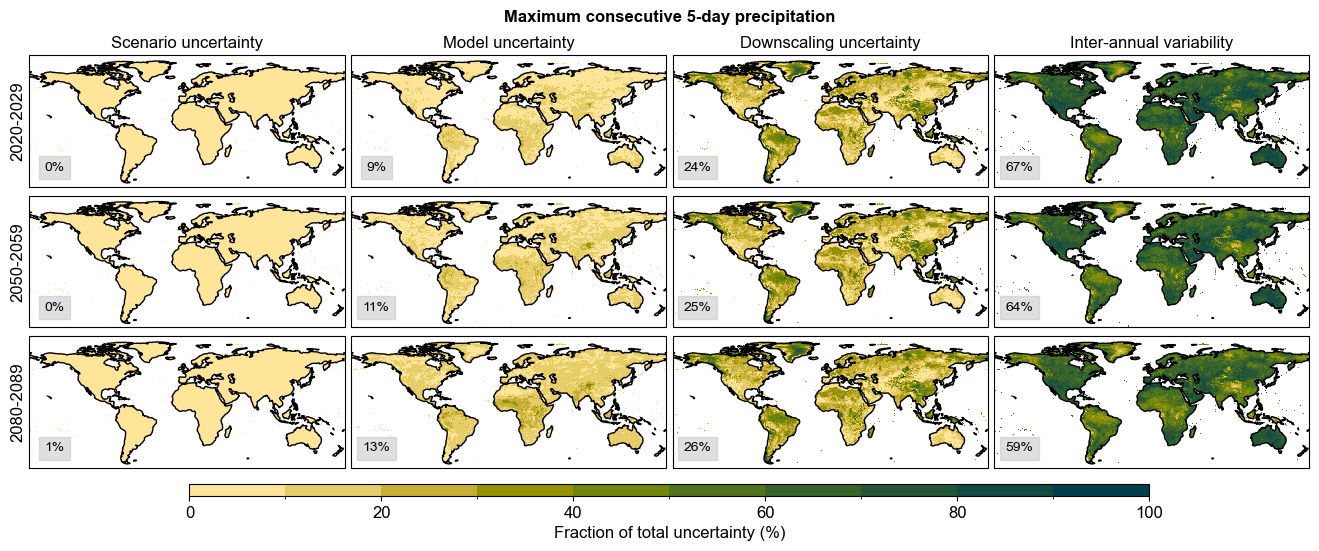

In [60]:
plot_map(ds, 'RX5day', True, 'Maximum consecutive 5-day precipitation', 'pr_max5d_iav')

### Dry days

In [61]:
# Read
ds_uc = xr.open_dataset(path_in + 'hs09_iav/dry.nc').isel(member_id=0)

ds_iav = xr.open_dataset(path_in + 'hs09_iav/dry_iav.nc').isel(member_id=0)
ds_iav = ds_iav.expand_dims(dim={'time':np.arange(2020,2095)}).assign_coords(uncertainty = 'variability')

ds = xr.concat([ds_iav, ds_uc], dim='uncertainty')

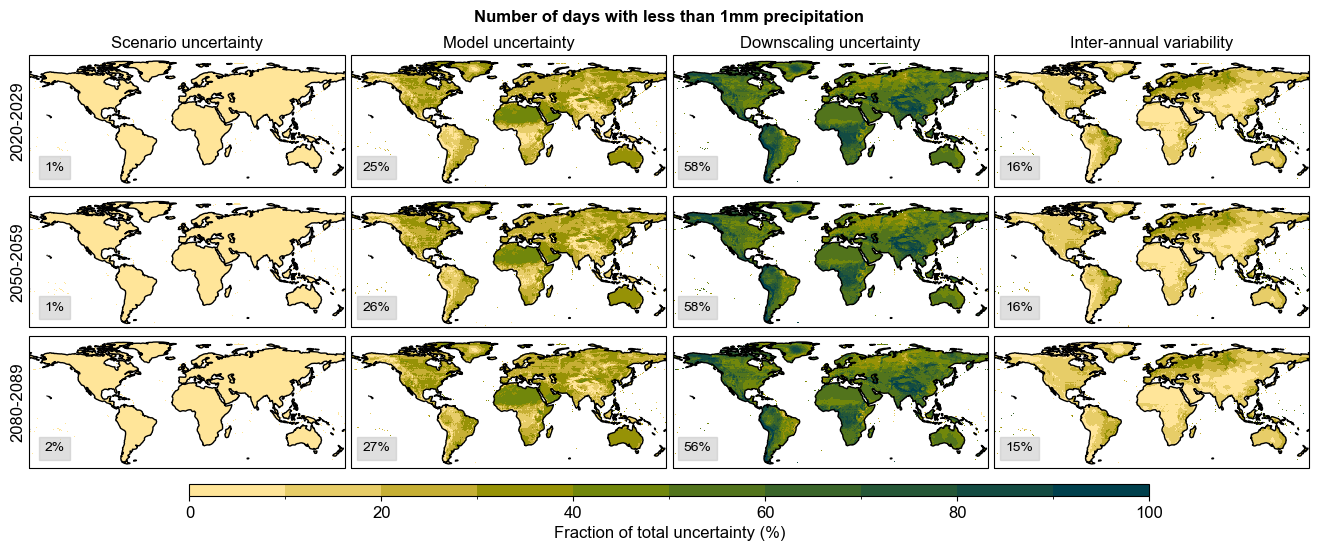

In [62]:
plot_map(ds, 'count_lt_1', True, 'Number of days with less than 1mm precipitation', 'pr_lt1count_iav')

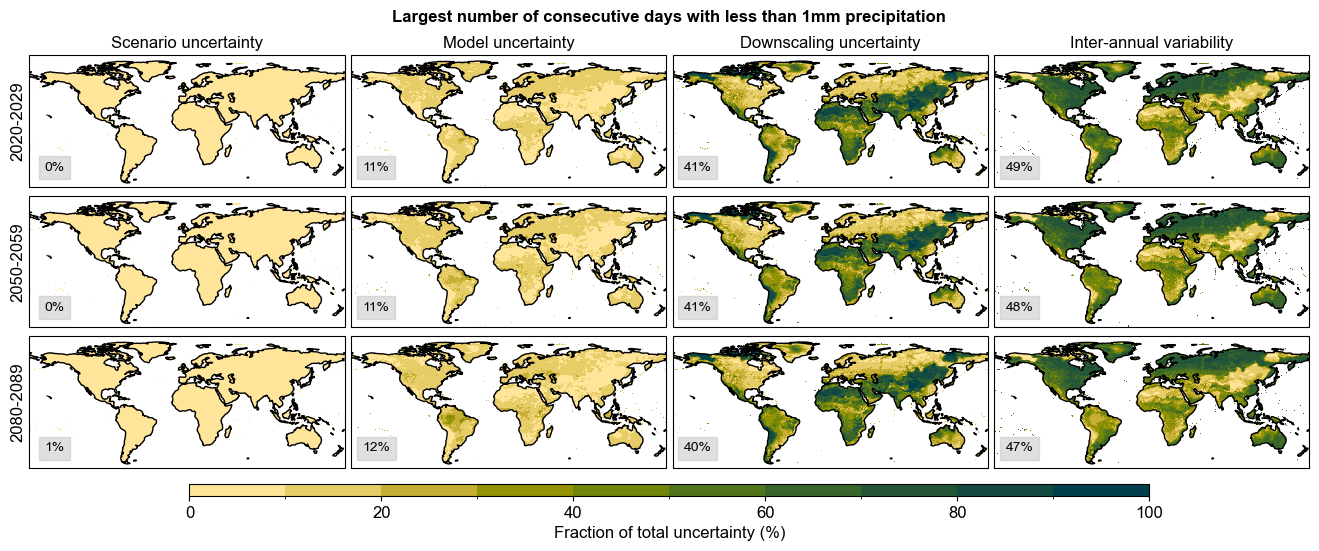

In [63]:
plot_map(ds, 'streak_lt_1', True, 'Largest number of consecutive days with less than 1mm precipitation', 'pr_lt1streak_iav')

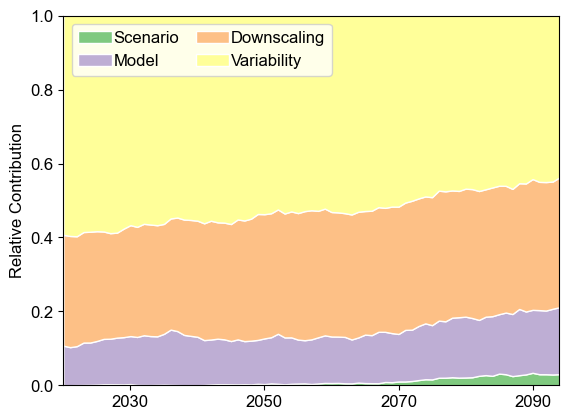

In [42]:
# Seattle
plot_single_point(ds, 'streak_lt_1', 47.6, -122.3, True)

### Hot days (tasmax GMFD RP5)

In [42]:
# Read
ds_uc = xr.open_dataset(path_in + 'hs09_iav/hot_tasmax_rp5gmfd.nc').isel(member_id=0)

ds_iav = xr.open_dataset(path_in + 'hs09_iav/hot_tasmax_rp5gmfd_iav.nc').isel(member_id=0)
ds_iav = ds_iav.expand_dims(dim={'time':np.arange(2020,2095)}).assign_coords(uncertainty = 'variability')

ds = xr.concat([ds_iav, ds_uc], dim='uncertainty')

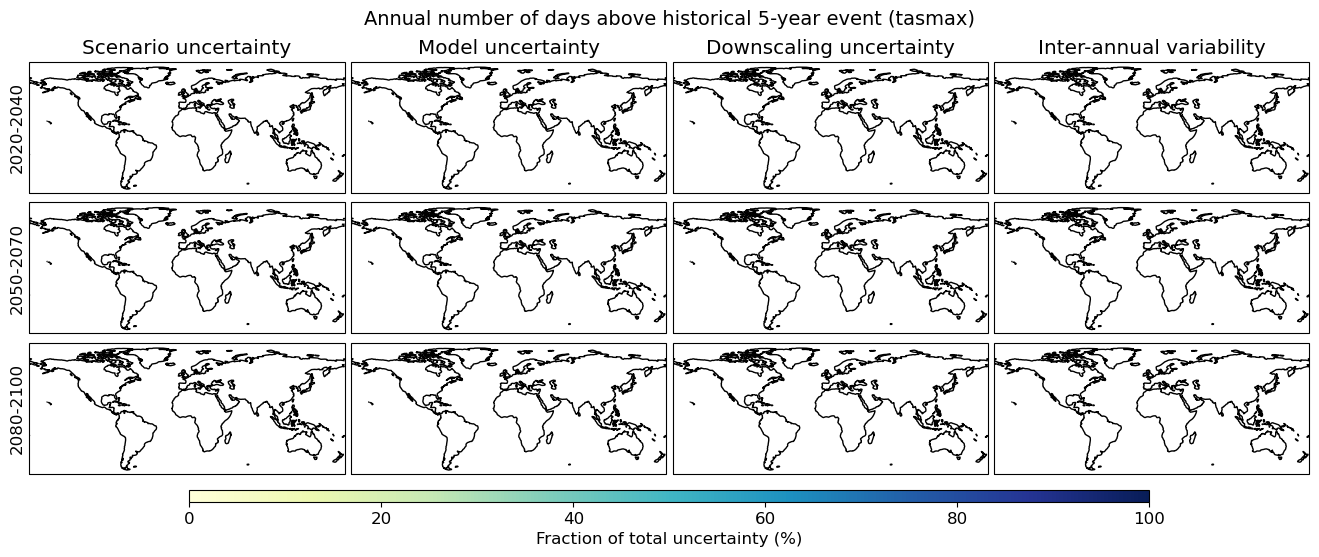

In [47]:
plot_map_iav(ds, 'tasmax_rp5gmfd_count', 'Annual number of days above historical 5-year event (tasmax)', False)

In [ ]:
plot_map_iav(ds, 'tasmax_rp5gmfd_count', 'Annual number of days above historical 5-year event (tasmax)', False)

### Wet days (GMFD RP5)

In [51]:
# Read
ds_uc = xr.open_dataset(path_in + 'hs09_iav/wet_rp5gmfd.nc').isel(member_id=0)

ds_iav = xr.open_dataset(path_in + 'hs09_iav/wet_rp5gmfd_iav.nc').isel(member_id=0)
ds_iav = ds_iav.expand_dims(dim={'time':np.arange(2020,2095)}).assign_coords(uncertainty = 'variability')

ds = xr.concat([ds_iav, ds_uc], dim='uncertainty')

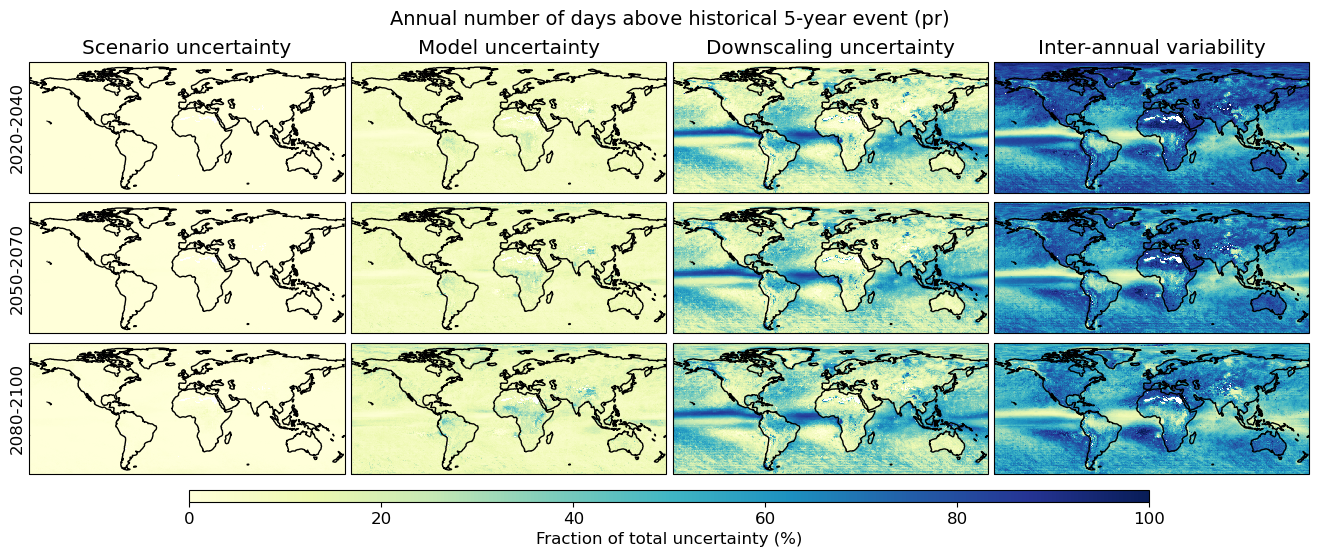

In [53]:
plot_map_iav(ds, 'pr_rp5gmfd_count', 'Annual number of days above historical 5-year event (pr)', False)

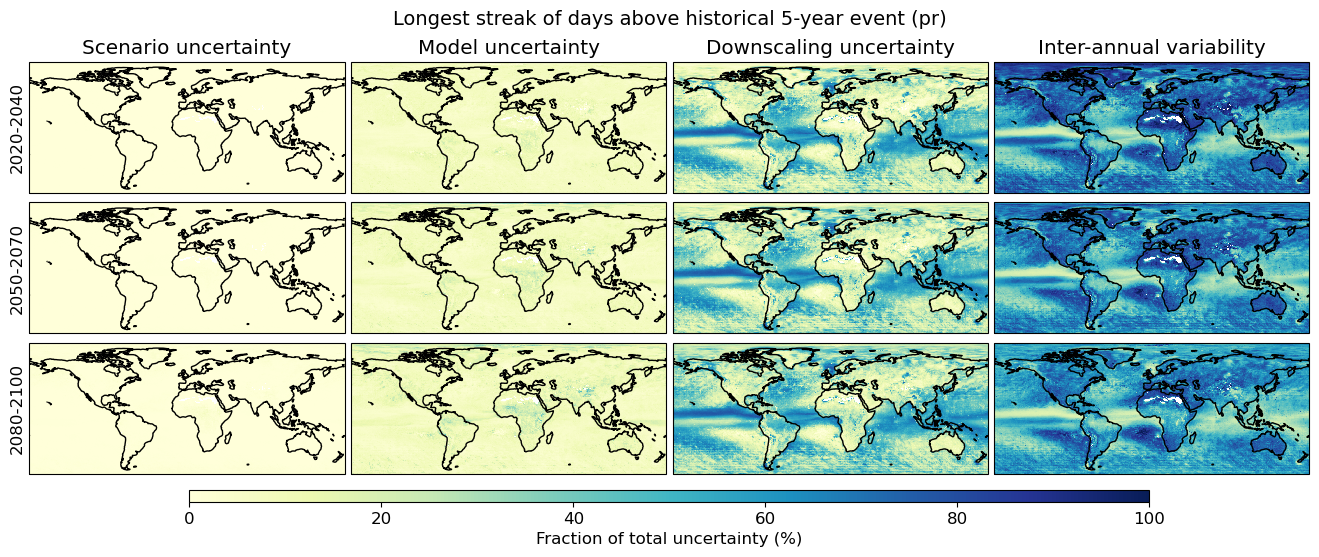

In [54]:
plot_map_iav(ds, 'pr_rp5gmfd_streak', 'Longest streak of days above historical 5-year event (pr)', False)

## UC plots without IAV

### Annual averages

In [23]:
# Read
ds = xr.open_dataset(path_in + 'annual_avgs_HS09.nc')

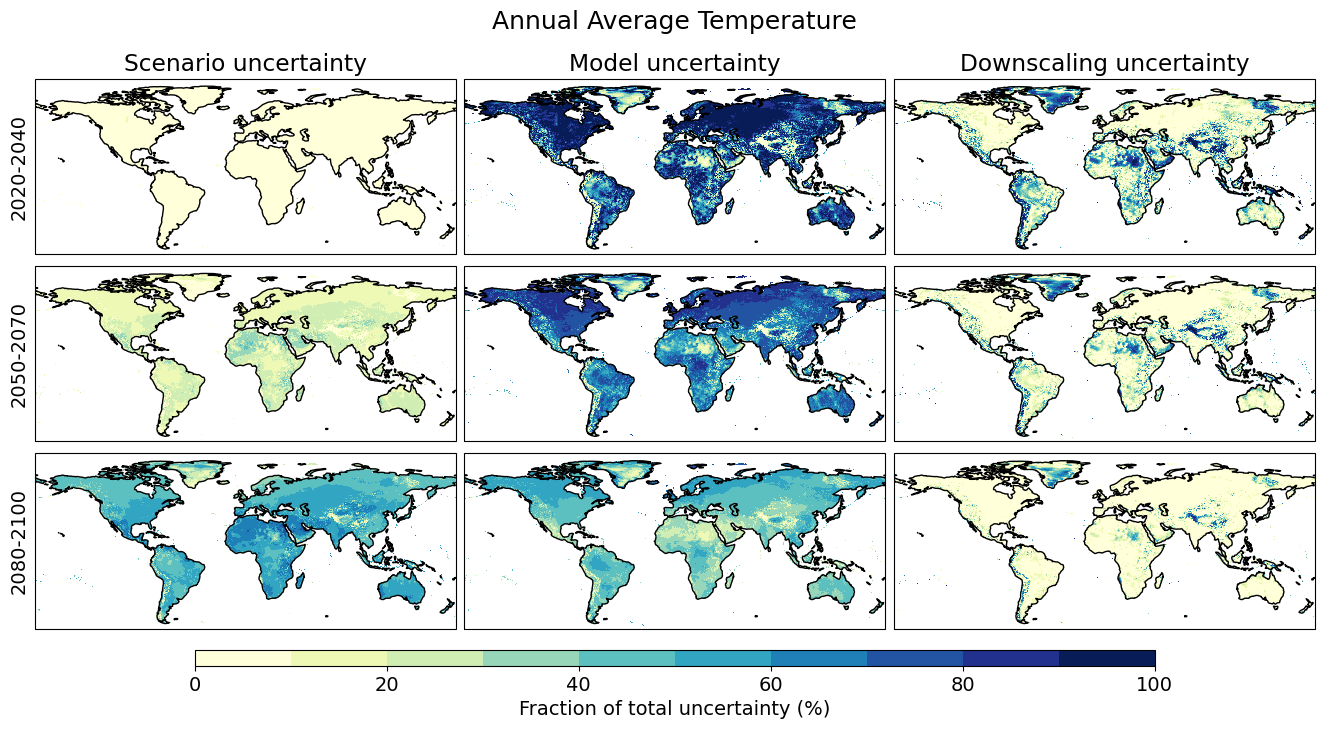

In [24]:
plot_map(ds, 'tas', 'Annual Average Temperature', 'tas_avg_hs09_map')

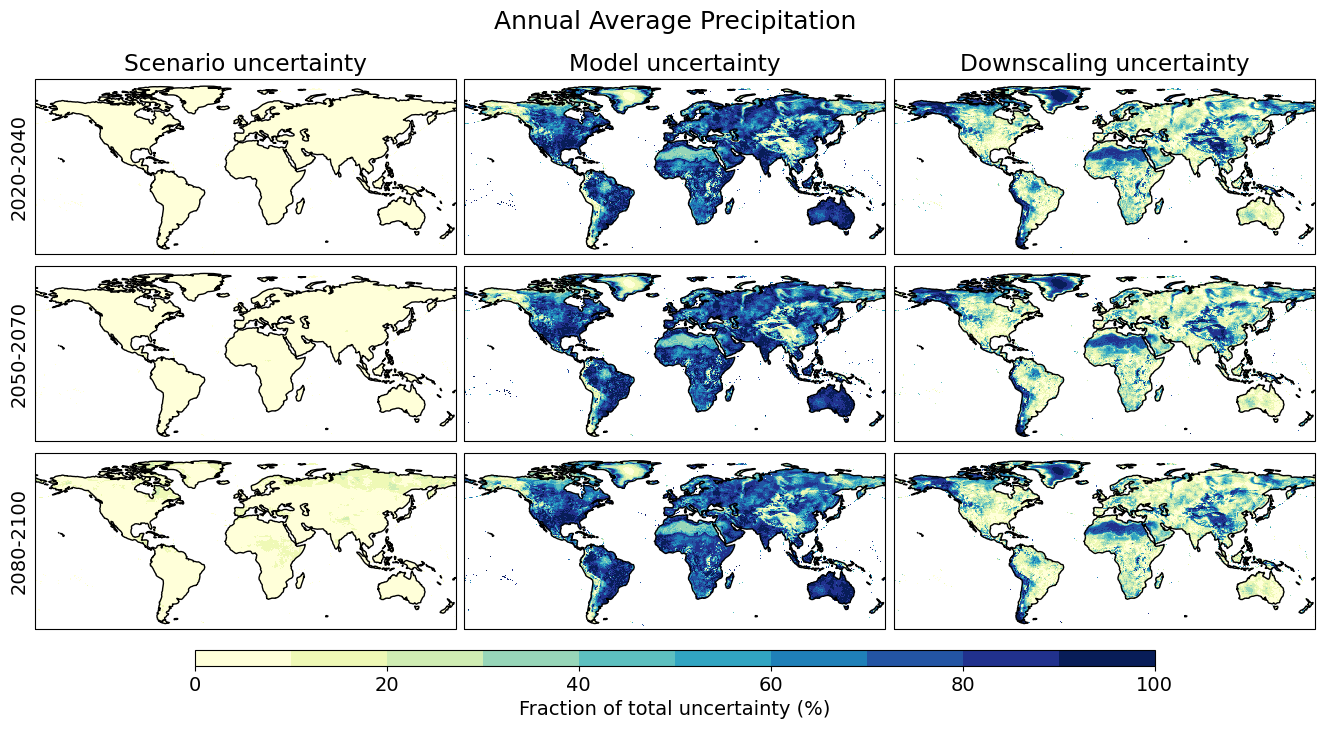

In [25]:
plot_map(ds, 'pr', 'Annual Average Precipitation', 'pr_avg_hs09_map')

### Annual maxs

In [26]:
# Read
ds = xr.open_dataset(path_in + 'annual_maxs_HS09.nc')

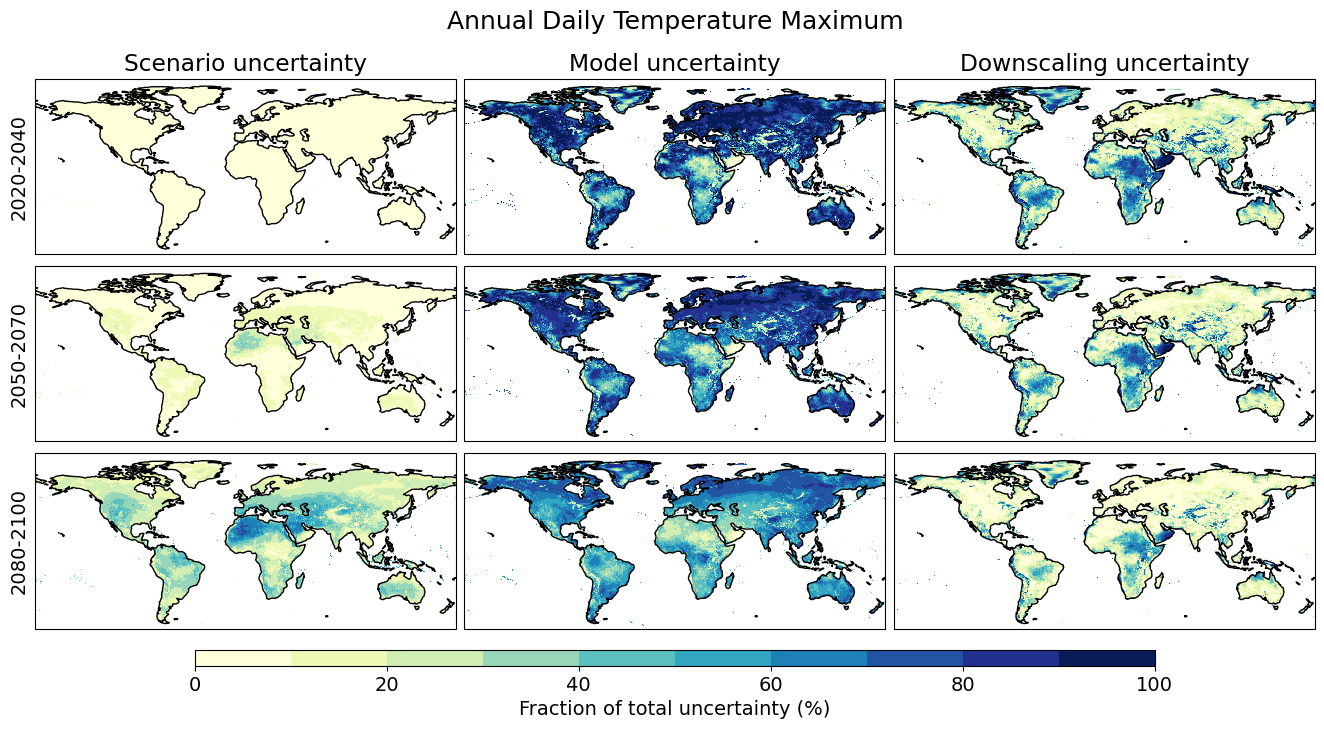

In [27]:
plot_map(ds, 'tasmax', 'Annual Daily Temperature Maximum', 'tasmax_max_hs09_map')

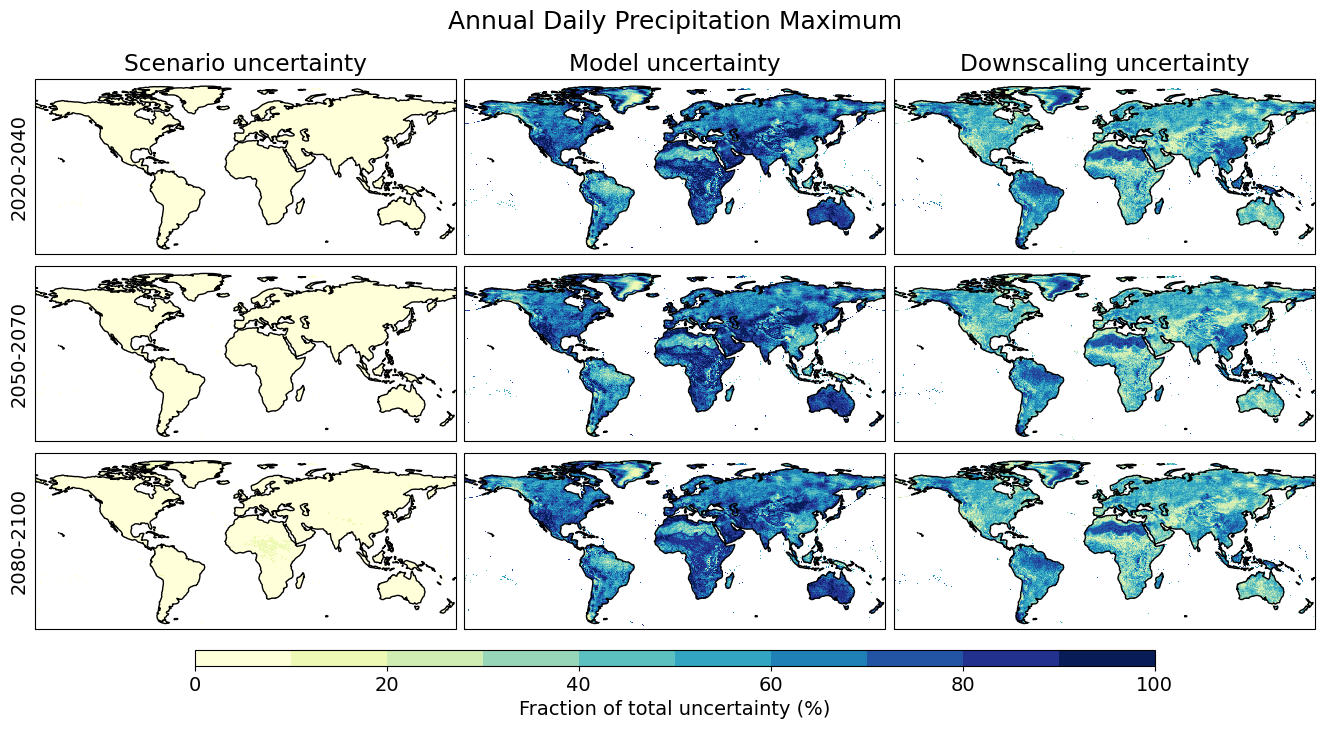

In [28]:
plot_map(ds, 'pr', 'Annual Daily Precipitation Maximum', 'pr_max_hs09_map')